# NYC Yellow Taxi Travel Time Prediction

In [2]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pygeohash as pgh
import datetime
import warnings
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV 
from sklearn.externals import joblib
from sklearn.metrics import mean_squared_error,mean_squared_log_error , r2_score
from google.cloud import bigquery
from sklearn.ensemble import GradientBoostingRegressor
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="4990-fcffed95431b.json"
%matplotlib inline

def rain_level(prcp):
    if prcp==0.0:
        return 'No'
    elif (prcp>0.0) & (prcp<0.098):
        return 'Light'
    elif (prcp>=0.098) & (prcp<0.39):
        return 'Moderate'
    else:
        return 'Heavy'

def get_grid_cv(X_train,y_train,model,param_grid,fold,score,core):
    grid_search = GridSearchCV(model, param_grid, cv=fold,
    scoring=score,n_jobs = core,verbose =10) 
    grid_search.fit(X_train,y_train)
    return grid_search

def get_measure(y_test,y_pred):
    RMSE =np.sqrt(mean_squared_error(y_test,y_pred))
    RMSLE=np.sqrt(mean_squared_log_error(y_test,y_pred))
    R_score = r2_score(y_test,y_pred)
    print('RMSE:',RMSE,'\nRMSLE:',RMSLE,'\nR2:',R_score)

def show_cv_results(grid): 
    c = grid.cv_results_
    for mean_score, params in zip(c["mean_test_score"], c["params"]): 
        print(np.sqrt(-mean_score), params)
     
    
def show_grid_cv(grid,para,para_name):
    RMSE_train = np.sqrt(-grid.cv_results_['mean_train_score'])
    RMSE_test = np.sqrt(-grid.cv_results_['mean_test_score'])
    if para_name:
        fig=plt.figure()
        ax = fig.add_axes([0,0,1,1])
        ax.plot(para,RMSE_train,label='Train loss')
        ax.plot(para,RMSE_test,label = 'Validation loss')
        ax.legend(loc=0)
        plt.title('Root mean square error over {}'.format(para_name))
        plt.xlabel(para_name)
        plt.ylabel('rmse')
        plt.show
    else:
        fig=plt.figure()
        ax = fig.add_axes([0,0,1,1])
        ax.plot(RMSE_train,label='Train loss')
        ax.plot(RMSE_test,label = 'Validation loss')
        ax.legend(loc=0)
        plt.title('Root mean square error')
        plt.xlabel('parameters set')
        plt.ylabel('rmse')
        plt.show
        
def show_feature_importance(feature,model):
    feature_importance = model.feature_importances_
    feat = pd.DataFrame(feature_importance)
    feat_name = pd.DataFrame(feature)
    feat_df = pd.concat([feat_name,feat],axis=1)
    feat_df.columns = ["feature","feature_score"]
    feat_df =feat_df.sort_values(by = "feature_score")
    feat_df=feat_df.reset_index(drop=True)
    feat_df[-15:].plot.barh(x='feature',y = 'feature_score',align='center',color = '#1f77b4')

## I.Data Processing

### Wrote SQL pipeline to extract data from BigQuery

In [39]:
start = time.time()
client = bigquery.Client()

query = (
   """
  CREATE TEMP FUNCTION RADIANS(x FLOAT64) AS (
  ACOS(-1) * x / 180
);
CREATE TEMP FUNCTION RADIANS_TO_KM(x FLOAT64) AS (
  111.045 * 180 * x / ACOS(-1)
);
CREATE TEMP FUNCTION HAVERSINE(lat1 FLOAT64, long1 FLOAT64,
                               lat2 FLOAT64, long2 FLOAT64) AS (
  RADIANS_TO_KM(
    ACOS(ROUND(COS(RADIANS(lat1)) * COS(RADIANS(lat2)) *
         COS(RADIANS(long1) - RADIANS(long2)) +
         SIN(RADIANS(lat1)) * SIN(RADIANS(lat2)),15)))
);


select t1.pickup_datetime,EXTRACT(hour from t1.pickup_datetime) as Hour,t1.trip_distance,t1.passenger_count,TIMESTAMP_DIFF( TIMESTAMP(t1.dropoff_datetime),TIMESTAMP (t1.pickup_datetime), SECOND) as travel_time,t1.fare_amount,HAVERSINE(t1.dropoff_latitude,t1.dropoff_longitude, t1.pickup_latitude,t1.pickup_longitude) AS distance_in_km,t1.pickup_longitude, t1.pickup_latitude, t1.dropoff_longitude, t1.dropoff_latitude,if(EXTRACT(dayofweek from pickup_datetime)=6 or EXTRACT(dayofweek from pickup_datetime)=7, 0,1) as week_index,weather.*

from 
(select  pickup_datetime,passenger_count, trip_distance,dropoff_datetime,pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, 
row_number()over(partition by EXTRACT(date from pickup_datetime),EXTRACT(hour from pickup_datetime)
                   order by  EXTRACT(date from pickup_datetime),EXTRACT(hour from pickup_datetime)) as row_num,fare_amount
from `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2016`) as t1
join
    (
     select concat(year,'-',mo,'-',da) as date_of_year2,year,mo,da,temp,visib,wdsp,prcp,fog,rain_drizzle,snow_ice_pellets
     from `bigquery-public-data.noaa_gsod.gsod2016` where stn='725053'
    ) as weather
    on TIMESTAMP( EXTRACT (DATE from t1.pickup_datetime)) = TIMESTAMP(weather.date_of_year2)

where row_num <=300 and t1.pickup_latitude is not null and t1.pickup_longitude is not null and t1.dropoff_longitude is not null and HAVERSINE(t1.dropoff_latitude,t1.dropoff_longitude, t1.pickup_latitude,t1.pickup_longitude)>0.1
   """
)
df=pd.io.gbq.read_gbq(query,dialect='standard')
sql_time= time.time()-start
print(sql_time)

399.299320936203


In [ ]:
df.to_csv("one_million.csv",index = False)

### Handle Missing values of weather data

In [61]:
df.isnull().sum()

pickup_datetime      0
Hour                 0
trip_distance        0
passenger_count      0
travel_time          0
fare_amount          0
distance_in_km       0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
week_index           0
date_of_year2        0
year                 0
mo                   0
da                   0
temp                 0
visib                0
wdsp                 0
prcp                 0
fog                  0
rain_drizzle         0
snow_ice_pellets     0
dtype: int64

### From the description of weather data, the variable prcp,visib,wdsp contain missing values as 999.99 and temp contains missing value as 9999.99

In [118]:
df.wdsp = df.wdsp.astype('float')
df[['temp','prcp','visib','wdsp']].describe()

,temp,prcp,visib,wdsp
count,1.274188e+06,1.274188e+06,1.274188e+06,1.274188e+06
mean,5.125035e+01,9.678631e-02,3.093801e+01,3.255670e+01
std,1.555277e+01,2.512442e-01,1.455514e+02,1.629413e+02
min,6.900000e+00,0.000000e+00,1.700000e+00,1.200000e+00
25%,3.910000e+01,0.000000e+00,8.700000e+00,3.700000e+00
50%,5.140000e+01,0.000000e+00,9.800000e+00,4.900000e+00
75%,6.340000e+01,5.000000e-02,1.000000e+01,6.400000e+00
max,7.960000e+01,1.820000e+00,9.999000e+02,9.999000e+02


### From the table, it shows there are 999.99 values in the visib(visibility) and wdsp(wind speed) variable. We replace them with missing value first.

In [119]:
df['visib'] = df['visib'].replace(999.9, np.nan)
df['wdsp'] = df['wdsp'].replace(999.9, np.nan)

In [120]:
df.isnull().sum()

pickup_datetime          0
Hour                     0
trip_distance            0
passenger_count          0
travel_time              0
fare_amount              0
distance_in_km           0
pickup_longitude         0
pickup_latitude          0
dropoff_longitude        0
dropoff_latitude         0
week_index               0
date_of_year2            0
year                     0
mo                       0
da                       0
temp                     0
visib                28114
wdsp                 35149
prcp                     0
fog                      0
rain_drizzle             0
snow_ice_pellets         0
dtype: int64

### The above shows that visibility has over 28k missing values and wind speed variable has over 35k missing values. We refill visib and wdsp using forward method which propagates last valid observation forward to next valid and refill prcp with 0

In [121]:
df['visib'] = df['visib'].fillna(method='ffill')
df['wdsp'] = df['wdsp'].fillna(method='ffill')              

### Remove outliers of trip records

In [122]:
shape_before = df.shape
shape_before

(1274188, 23)

In [124]:
df[['trip_distance', 'passenger_count','travel_time', 'fare_amount', 'distance_in_km']].describe()

,trip_distance,passenger_count,travel_time,fare_amount,distance_in_km
count,1.274188e+06,1.274188e+06,1.274188e+06,1.274188e+06,1.274188e+06
mean,4.079502e+00,1.657586e+00,1.013648e+03,1.516606e+01,4.512260e+01
std,3.082005e+02,1.313311e+00,1.054046e+04,5.569563e+02,5.934157e+02
min,0.000000e+00,0.000000e+00,-7.411217e+06,-2.750000e+02,1.000813e-01
25%,1.100000e+00,1.000000e+00,4.080000e+02,7.000000e+00,1.375161e+00
50%,2.000000e+00,1.000000e+00,7.060000e+02,1.000000e+01,2.469194e+00
75%,4.400000e+00,2.000000e+00,1.172000e+03,1.800000e+01,5.326640e+00
max,3.180000e+05,9.000000e+00,6.445984e+06,6.285447e+05,1.255801e+04


### From the table above, we see there exists trips with negative travel time, zero trip_distance, and zero passenger trips

###  Check there are values less than 2.5 in the fare_amount variable since the starting price for a trip of the yellow cab is 2.5.

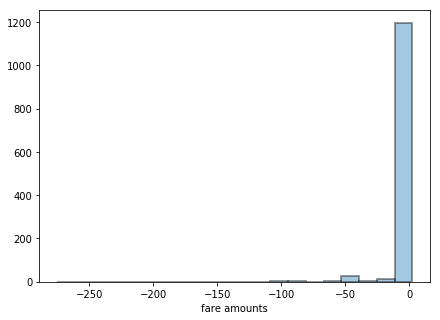

In [125]:
plt.figure(figsize = (7,5))
sns.distplot(df[df['fare_amount']<2.5]['fare_amount'],kde=False,bins=20,hist_kws=dict(edgecolor="k", linewidth=2),axlabel='fare amounts')

### Remove trips with fare amount less than 2.5 , zero passenger counts, and zero trip distance. Besides, we remove travel time larger than two hours and less than one minute.

In [126]:
df = df[(df.fare_amount>=2.5) & (df.passenger_count>0)]
df = df[(df.travel_time>=60) &(df.travel_time<7200)]
df = df[df.trip_distance!=0]

### We restrict the longitude and latitude within the New York City

In [32]:
lon = [-74.03, -73.77]
lat = [40.63, 40.85]
df = df[(df.pickup_longitude> lon[0]) & (df.pickup_longitude < lon[1])]
df = df[(df.dropoff_longitude> lon[0]) & (df.dropoff_longitude < lon[1])]
df = df[(df.pickup_latitude> lat[0]) & (df.pickup_latitude < lat[1])]
df = df[(df.dropoff_latitude> lat[0]) & (df.dropoff_latitude < lat[1])]

In [39]:
df.shape

(1230382, 23)

In [40]:
num_removed = shape_before[0]- df.shape[0]
num_removed

43806

### After the data processing part, we removed over 43k outliers.

In [335]:
df = df.reset_index(drop=True)
df.to_csv('cleanned.csv',index=False)

## II.Feature Engineering

In [10]:
df = df[['pickup_datetime', 'Hour', 'trip_distance',
       'travel_time', 'distance_in_km', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'week_index','mo', 'da', 'temp', 'visib',
       'wdsp', 'prcp', 'fog', 'rain_drizzle', 'snow_ice_pellets']]

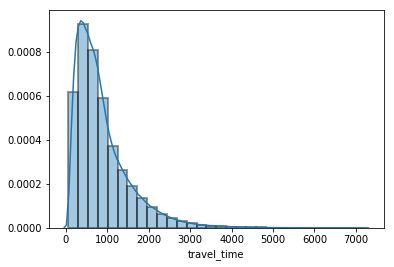

In [13]:
sns.distplot(df['travel_time'], axlabel = 'travel_time', bins = 30,hist_kws=dict(edgecolor="k", linewidth=2))

### The plot shows that the distribution of travel time is right-skewed due to the long travel time of some trips. So we apply log transformation to it.

### Log transformation of travel time

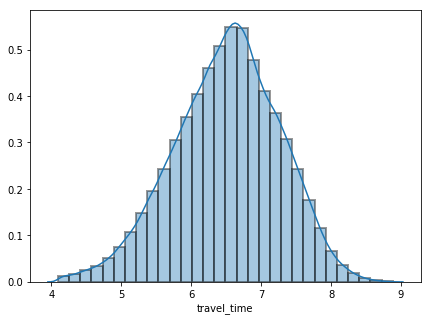

In [8]:
df['travel_time'] = np.log(df['travel_time'])
plt.figure(figsize = (7,5))
sns.distplot(df['travel_time'], axlabel = 'travel_time', bins = 30,hist_kws=dict(edgecolor="k", linewidth=2))

### Now the distribution of travel time is normal.

### Convert categorical features into one hot encoded dummy variables.

In [43]:
start = time.time()
#Construct rain features
df['rain_level'] = df.apply(lambda x: rain_level(x['prcp']),axis=1)
df = pd.get_dummies(df,columns=['rain_level'],prefix=['rain'],drop_first=True)
end = time.time()
print('The rain features cost {} seconds'.format(round(end - start,2)))

The rain features cost 10.76 seconds


### In New York City, we consider the rush hour is from 7:00 to 11:00 and 15:00 to 20:00, We assign 1 if pickup time in rush hours  0 otherwise.

In [44]:
start = time.time()
#Construct rush hour feature
rush_hour = [7,8,9,10,15,16,17,18,19]
df['rush_hour_ind']=df['Hour'].apply(lambda x: 1 if x in rush_hour else 0)
end = time.time()
print('The rush hour feature cost {} seconds'.format(round(end - start,2)))

The rush hour feature cost 0.38 seconds


###  Adding Geohash feature based on latitude and longtitude variables

### We use the average historical travel time in terms of the same pickup area and drop-off area, with geohash precision = 6. For example, if someone travels from abcdef (geohash code) to abcdeg (geohash code) at 15:00 on May 15th, we calculate the average historical travel time for trips that traveled from abcdef to abcdeg.

In [45]:
start = time.time()
# We obtain geohash with precision = 6 for all data
df['pickup_geohash'] = df.apply(lambda x: pgh.encode(x['pickup_latitude'], x['pickup_longitude'],precision=6), axis=1)
df['dropoff_geohash'] = df.apply(lambda x: pgh.encode(x['dropoff_latitude'], x['dropoff_longitude'],precision=6), axis=1)
df['gh'] = df['pickup_geohash'] + df['dropoff_geohash']

# We calculate average historical ‘travel time’ in terms of the same pickup area and drop off area, with geohash precision = 6.
df_transform = df.sort_values('pickup_datetime').groupby(['gh'])['travel_time'].transform('shift')
df_transform = pd.DataFrame(df_transform)
df_transform.columns = ['travel_time_shift']
df = pd.concat([df,df_transform],axis=1)
result = df.sort_values('pickup_datetime').groupby(['gh'])['travel_time_shift'].expanding().mean()
result = pd.DataFrame(result)
result = result.reset_index(level=0,drop=True)
result.columns = ['avg_travel_time']
df = pd.concat([df,result],axis=1)

# We calculate average historical 'trip distance' in terms of the same pickup area and drop off area, with geohash precision = 6.
df_transform = df.sort_values('pickup_datetime').groupby(['gh'])['trip_distance'].transform('shift')
df_transform = pd.DataFrame(df_transform)
df_transform.columns = ['travel_dist_shift']
df = pd.concat([df,df_transform],axis=1)
result = df.sort_values('pickup_datetime').groupby(['gh'])['travel_dist_shift'].expanding().mean()
result = pd.DataFrame(result)
result = result.reset_index(level=0,drop=True)
result.columns = ['avg_trip_dist']
df = pd.concat([df,result],axis=1)
end = time.time()
print('The geohash features cost {} mins'.format(round((end - start)/60,2)))

The geohash features cost 1.38 mins


In [47]:
df = df.drop(['pickup_datetime','trip_distance','mo','da','prcp','pickup_geohash','travel_time_shift','dropoff_geohash','gh','travel_dist_shift'],axis=1)
df.isnull().sum()

Hour                     0
travel_time              0
distance_in_km           0
pickup_longitude         0
pickup_latitude          0
dropoff_longitude        0
dropoff_latitude         0
week_index               0
temp                     0
visib                    0
wdsp                     0
fog                      0
rain_drizzle             0
snow_ice_pellets         0
rain_Light               0
rain_Moderate            0
rain_No                  0
rush_hour_ind            0
avg_travel_time      51676
avg_trip_dist        51676
dtype: int64

### Since some trips don't have historical records, the geohash features will be filled with 0

In [48]:
df = df.fillna(0)

### Adding K-means Clustering features based on pickup and dropoff locations

In [50]:
df_kmean = df[['pickup_longitude','pickup_latitude','dropoff_latitude','dropoff_longitude']]
df_kmean.head()

,pickup_longitude,pickup_latitude,dropoff_latitude,dropoff_longitude
0,-73.980690,40.733959,40.745708,-73.975929
1,-73.980324,40.759773,40.769363,-73.960686
2,-73.989197,40.757729,40.786228,-73.975983
3,-73.965927,40.762650,40.793339,-73.940529
4,-73.981026,40.729553,40.730923,-74.002884


In [51]:
kmean = KMeans(n_clusters=20,random_state=0)
kmean.fit(df_kmean)
df_kmean['label'] = kmean.labels_

### Visuliaze the K-means Clustering features

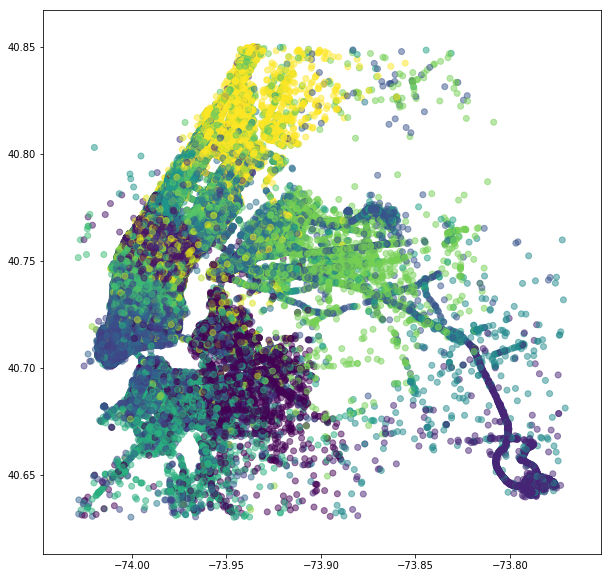

In [52]:
plt.figure(figsize = (10,10))
xs = df_kmean.pickup_longitude
ys = df_kmean.pickup_latitude
labels = df_kmean.label
plt.scatter(xs, ys, c=labels, alpha=0.5)
plt.show()

In [53]:
df['kmeans'] = df_kmean.label

In [54]:
df.head()

,Hour,travel_time,distance_in_km,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,week_index,temp,visib,wdsp,fog,rain_drizzle,snow_ice_pellets,rain_Light,rain_Moderate,rain_No,rush_hour_ind,avg_travel_time,avg_trip_dist,kmeans
0,23,5.916202,1.364800,-73.980690,40.733959,-73.975929,40.745708,0,41.2,9.5,3.8,0,0,0,0,0,1,0,5.852023,1.008571,13
1,23,6.161207,1.965221,-73.980324,40.759773,-73.960686,40.769363,0,41.2,9.5,3.8,0,0,0,0,0,1,0,5.982553,0.910968,17
2,23,6.371612,3.354170,-73.989197,40.757729,-73.975983,40.786228,0,41.2,9.5,3.8,0,0,0,0,0,1,0,6.448090,2.255405,10
3,23,6.583409,4.021803,-73.965927,40.762650,-73.940529,40.793339,0,41.2,9.5,3.8,0,0,0,0,0,1,0,6.240136,2.881818,7
4,23,6.602588,1.845618,-73.981026,40.729553,-74.002884,40.730923,0,41.2,9.5,3.8,0,0,0,0,0,1,0,6.338464,1.316667,13


In [57]:
df.to_csv('my_version/features1.csv',index=False)

In [58]:
df_corr_cat = df[['fog','rain_drizzle','snow_ice_pellets','week_index','rain_Light','rain_Moderate','rain_No','rush_hour_ind','travel_time']]

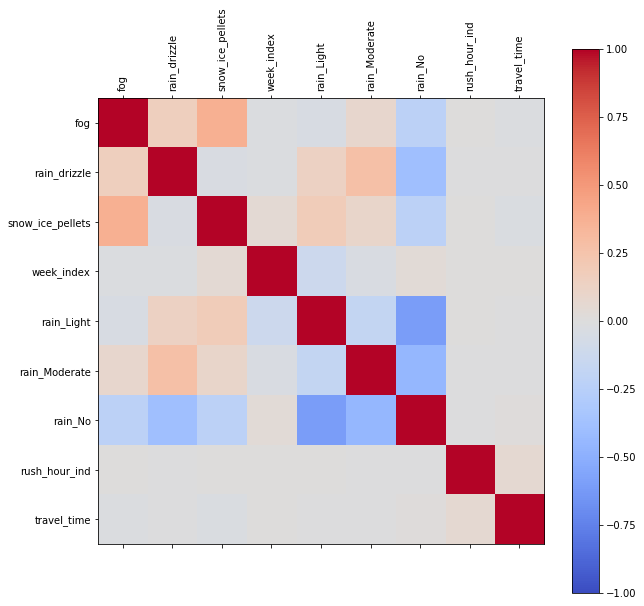

In [59]:
corr = df_corr_cat.corr()
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(df_corr_cat.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(df_corr_cat.columns)
ax.set_yticklabels(df_corr_cat.columns)
plt.show()

### From the heatmap above, the correlations bewteen categorical variables are weak.

In [60]:
df[['distance_in_km','avg_travel_time','avg_trip_dist','travel_time']].corr()

,distance_in_km,avg_travel_time,avg_trip_dist,travel_time
distance_in_km,1.000000,0.147178,0.178116,0.684106
avg_travel_time,0.147178,1.000000,0.100825,0.214421
avg_trip_dist,0.178116,0.100825,1.000000,0.119980
travel_time,0.684106,0.214421,0.119980,1.000000


# Model Selection, Comparison and Cross Validation

In [5]:
df = pd.read_csv('my_version/features1.csv')

In [6]:
df.columns

Index(['Hour', 'travel_time', 'distance_in_km', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'week_index', 'temp', 'visib', 'wdsp', 'fog', 'rain_drizzle',
       'snow_ice_pellets', 'rain_Light', 'rain_Moderate', 'rain_No',
       'rush_hour_ind', 'avg_travel_time', 'avg_trip_dist', 'kmeans'],
      dtype='object')

In [7]:
X = df.drop(['travel_time'],axis =1)
y = df['travel_time']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Random Forest

In [78]:
min_split =  np.arange(10,110,10)
grid_min_samples_split= get_grid_cv(X_train,y_train,RandomForestRegressor(random_state=0,max_features='sqrt'),
                               param_grid = {'min_samples_split':min_split},fold=3,score='neg_mean_squared_error',core =-1)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   38.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   57.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:  2.0min remaining:   13.6s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.3min finished


In [81]:
grid_min_samples_split.best_params_

{'min_samples_split': 20}

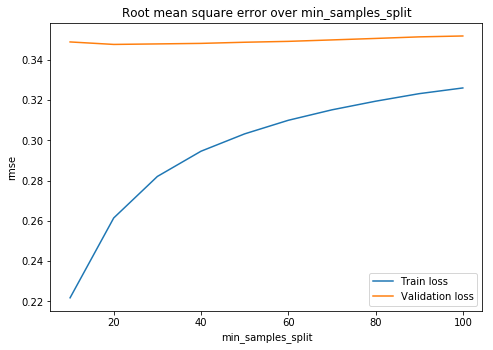

In [80]:
show_grid_cv(grid_min_samples_split,min_split,'min_samples_split')

####  From the plot, we see the small number of min_samples_split will cause overfitting since the gap between validation error and training error is large. The increase of min_samples_split will decrease the overfitting issue, we pick a large number for min_samples_split.

In [66]:
max_dep = np.arange(10,55,5)
grid_max_depth= get_grid_cv(X_train,y_train,RandomForestRegressor(random_state=0,max_features='sqrt'),
                               param_grid = {'max_depth':max_dep},fold=3,score='neg_mean_squared_error',core =-1)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   46.5s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  23 out of  27 | elapsed:  2.1min remaining:   21.7s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  2.5min finished


In [67]:
grid_max_depth.best_params_

{'max_depth': 20}

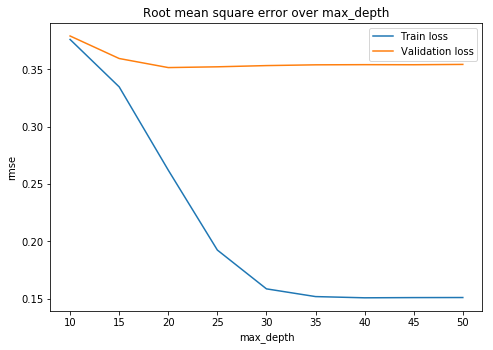

In [68]:
show_grid_cv(grid_max_depth,max_dep,'max_depth')

#### The GridSearchCV returns 20 for max_depth when the validation error is the lowest.  From the plot, we  see after max_depth = 20, the test error no longer decreases. However, the training error starts to fall rapidly, which causes overfitting. So we may pick max_depth from 15 to 20.

In [15]:
num_trees = np.arange(50,250,50)
grid_n_estimators= get_grid_cv(X_train,y_train,RandomForestRegressor(random_state=0,max_features='sqrt'),
                               param_grid = {'n_estimators':num_trees},fold=3,score='neg_mean_squared_error',core =1)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] n_estimators=50 .................................................
[CV] ...... n_estimators=50, score=-0.11347459662540509, total= 1.5min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.8min remaining:    0.0s


[CV] n_estimators=50 .................................................
[CV] ...... n_estimators=50, score=-0.11469143159535396, total= 1.5min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.5min remaining:    0.0s


[CV] n_estimators=50 .................................................
[CV] ...... n_estimators=50, score=-0.11435863022071861, total= 1.5min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  5.2min remaining:    0.0s


[CV] n_estimators=100 ................................................
[CV] ..... n_estimators=100, score=-0.11189810183313197, total= 2.9min


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  8.6min remaining:    0.0s


[CV] n_estimators=100 ................................................
[CV] ..... n_estimators=100, score=-0.11298830281310612, total= 2.9min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 12.0min remaining:    0.0s


[CV] n_estimators=100 ................................................
[CV] ..... n_estimators=100, score=-0.11292469207728636, total= 2.9min


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 15.3min remaining:    0.0s


[CV] n_estimators=150 ................................................
[CV] ...... n_estimators=150, score=-0.1113977200183118, total= 4.4min


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 20.4min remaining:    0.0s


[CV] n_estimators=150 ................................................
[CV] ..... n_estimators=150, score=-0.11259344101132333, total= 4.4min


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 25.5min remaining:    0.0s


[CV] n_estimators=150 ................................................
[CV] ...... n_estimators=150, score=-0.1124509447015308, total= 4.4min


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 30.5min remaining:    0.0s


[CV] n_estimators=200 ................................................
[CV] ..... n_estimators=200, score=-0.11107964844777352, total= 5.8min
[CV] n_estimators=200 ................................................
[CV] ..... n_estimators=200, score=-0.11234300835948925, total= 5.8min
[CV] n_estimators=200 ................................................
[CV] ..... n_estimators=200, score=-0.11222260476553708, total= 5.8min


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 50.8min finished


In [16]:
grid_n_estimators.best_params_

{'n_estimators': 200}

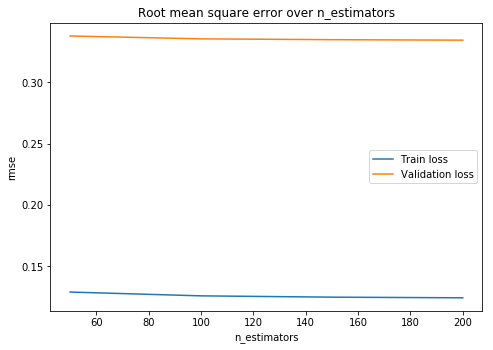

In [17]:
show_grid_cv(grid_n_estimators,num_trees,'n_estimators')

#### The GridSearchCV returns 200 for n_estimators when the validation error is the lowest. From the plot, we see the increase of n_estimators doesn't affect overfitting much since the gap between the validation error and the training error doesn't change much. So we pick the largest number for n_estimators here.

In [6]:
param = {'n_estimators': [200], 
              'max_depth': [16,18,20], 
              'min_samples_split':[30,40,50]
             }
grid_RF= get_grid_cv(X_train,y_train,RandomForestRegressor(random_state=0,max_features='sqrt'),
                            param_grid=param,fold=3,score='neg_mean_squared_error',core =-1)
grid_RF.best_params_

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 23.9min
[Parallel(n_jobs=-1)]: Done  23 out of  27 | elapsed: 29.9min remaining:  5.2min
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed: 34.7min finished


{'max_depth': 20, 'min_samples_split': 30, 'n_estimators': 200}

In [89]:
#forest_reg = RandomForestRegressor(max_depth=20,min_samples_split=30,max_features='sqrt',n_estimators=200,n_jobs=-1,random_state=0)
#forest_reg.fit(X_train,y_train)
#y_pred =forest_reg.predict(X_test)
#get_measure(y_test,y_pred)

RMSE: 0.34183678913057686 
RMSLE: 0.04787303913429366 
R2: 0.7972165236862805


In [90]:
#y_pred_train =forest_reg.predict(X_train)
#get_measure(y_train,y_pred_train)

RMSE: 0.30209307122216206 
RMSLE: 0.04226932957320144 
R2: 0.840654666936244


### We increase the min_samples_split to 100 to decrease the overfitting showed above.

In [91]:
forest_reg = RandomForestRegressor(max_depth=20,min_samples_split=100,max_features='sqrt',n_estimators=200,n_jobs=-1,random_state=0)
forest_reg.fit(X_train,y_train)
y_pred =forest_reg.predict(X_test)
get_measure(y_test,y_pred)

RMSE: 0.3467157445307337 
RMSLE: 0.04853938545981364 
R2: 0.7913866534023941


In [92]:
y_pred_train =forest_reg.predict(X_train)
get_measure(y_train,y_pred_train)

RMSE: 0.326578725245902 
RMSLE: 0.045667331796958296 
R2: 0.8137768800839262


### Top 15 features of Random Forest

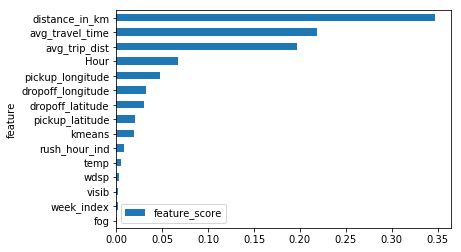

In [106]:
show_feature_importance(feature=X.columns, model=forest_reg)

## Gradient Boosting 

In [ ]:
GBR= GradientBoostingRegressor(random_state=0,verbose=2)
GBR_n_est = range(50,550,50)
param = {'n_estimators': GBR_n_est,  
         'learning_rate':[0.1],
         'max_depth': [3], 
         'min_samples_split':[100],
         'max_features': ['sqrt'],
         'subsample':[0.8]
        }
GBR_grid1 = get_grid_cv(X_train,y_train,GBR,param_grid=param,fold=3,score='neg_mean_squared_error',core =-1)
GBR_grid1.best_params_
'''
{'learning_rate': 0.1,
 'max_depth': 3,
 'max_features': 'sqrt',
 'min_samples_split': 100,
 'n_estimators': 500,
 'subsample': 0.8}

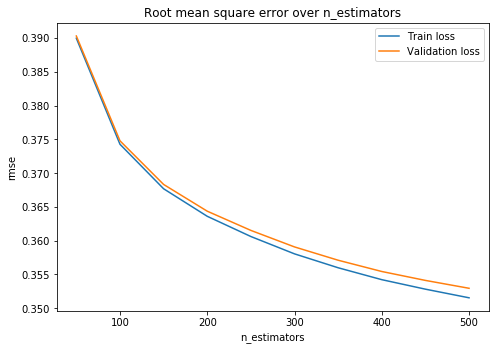

In [17]:
show_grid_cv(GBR_grid1,GBR_n_est,'n_estimators')

In [ ]:
GBR_max_dep = [5,7,9,11]
GBR_min_split= [50,100,150,200]
param = {'n_estimators':[500],  
         'learning_rate':[0.2],
         'max_depth': GBR_max_dep, 
         'min_samples_split':GBR_min_split,
         'max_features': ['sqrt'],
         'subsample':[0.8]
        }
GBR_grid2 = get_grid_cv(X_train,y_train,GBR,param_grid=param,fold=3,score='neg_mean_squared_error',core =-1)
GBR_grid2.best_params_

'''
{'learning_rate': 0.2,
 'max_depth': 11,
 'max_features': 'sqrt',
 'min_samples_split': 200,
 'n_estimators': 500,
 'subsample': 0.8}
'''

### Visualize each parameter set based on training error and validation error

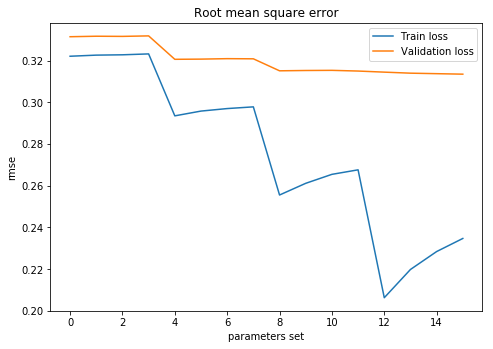

In [25]:
show_grid_cv(GBR_grid2,None,None)

### From the plot, we pick a parameter set that doesn't have much overfitting issue. Here, we may pick the seventh set.

In [35]:
GBR_grid2.cv_results_['params'][7]

{'learning_rate': 0.2,
 'max_depth': 7,
 'max_features': 'sqrt',
 'min_samples_split': 200,
 'n_estimators': 500,
 'subsample': 0.8}

In [ ]:
grid_best = {'learning_rate': 0.2,
 'max_depth': 7,
 'max_features': 'sqrt',
 'min_samples_split': 200,
 'n_estimators': 500,
 'subsample': 0.8,
 'verbose': 2}
boost_reg = GradientBoostingRegressor(**grid_best)
boost_reg.fit(X_train,y_train)

In [37]:
y_pred =boost_reg.predict(X_test)
get_measure(y_test,y_pred)

RMSE: 0.3186886227910974 
RMSLE: 0.044828965660812375 
R2: 0.823750423678861


In [38]:
y_pred_train =boost_reg.predict(X_train)
get_measure(y_train,y_pred_train)

RMSE: 0.3013315934070133 
RMSLE: 0.04219101082076553 
R2: 0.8414569694118501


In [39]:
###Try some larger number of min_sample_split with depth 11

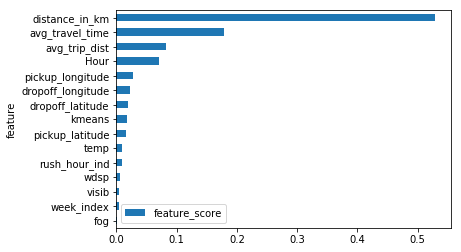

In [56]:
show_feature_importance(feature=X.columns, model=boost_reg)

In [2]:
All_R2 = pd.DataFrame(np.array([0.61,0.62,0.47, 0.75]))
R2_name = pd.DataFrame(['Linear','Lasso','Decision_Tree','Random_Forest'])
R2_bar = pd.concat([R2_name,All_R2],axis=1)
R2_bar.columns = ["Models","R2"]
R2_bar =R2_bar.sort_values(by = "R2")
R2_bar=R2_bar.reset_index(drop=True)

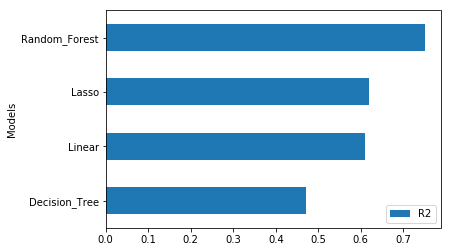

In [3]:
R2_bar.plot.barh(x= "Models",y = 'R2',align='center')

In [4]:
All_RMSE = pd.DataFrame(np.array([463.56,448.53,371.41,254.24]))
RMSE_name = pd.DataFrame(['Linear','Lasso','Decision_Tree','Random_Forest'])
RMSE_bar = pd.concat([RMSE_name,All_RMSE],axis=1)
RMSE_bar.columns = ["Models","RMSE"]
RMSE_bar =RMSE_bar.sort_values(by = "RMSE",ascending=False)
RMSE_bar=RMSE_bar.reset_index(drop=True)

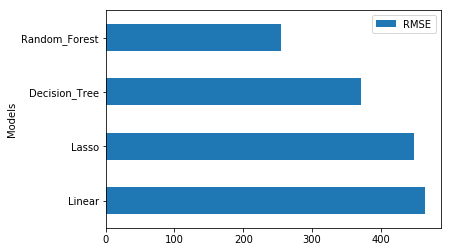

In [5]:
RMSE_bar.plot.barh(x= "Models",y = 'RMSE',align='center')

In [6]:
All_RMSLE = pd.DataFrame(np.array([0.194,0.439,0.499,0.358]))
RMSLE_name = pd.DataFrame(['Linear','Lasso','Decision_Tree','Random_Forest'])
RMSLE_bar = pd.concat([RMSLE_name,All_RMSLE],axis=1)
RMSLE_bar.columns = ["Models","RMSLE"]
RMSLE_bar =RMSLE_bar.sort_values(by = "RMSLE",ascending=False)
RMSLE_bar=RMSLE_bar.reset_index(drop=True)

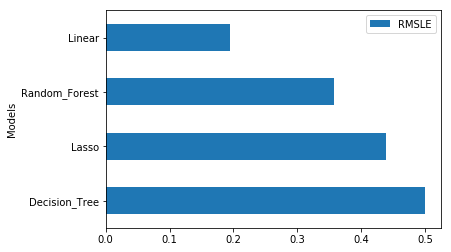

In [7]:
RMSLE_bar.plot.barh(x= "Models",y = 'RMSLE',align='center')

## Testing

### Combine weather data

In [27]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import pygeohash as pgh
pd.set_option('display.max_columns', 500)
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="4990-52a2635c2722.json"

In [28]:
from google.cloud import bigquery
client = bigquery.Client()
query=(
'''
select concat(year,'-',mo,'-',da) as date_of_year2,year,mo,da,temp,visib,wdsp,prcp,fog,rain_drizzle,snow_ice_pellets
from `bigquery-public-data.noaa_gsod.gsod2015` where stn='725053'
''')

weather_2015 = pd.io.gbq.read_gbq(query,dialect='standard')

In [33]:
df_test = pd.read_csv('APM4990_final_test_data_filtered.csv')

In [34]:
df_test.insert(loc=0,column = 'datetime', value =pd.to_datetime(df_test['pickup_datetime']))
df_test.insert(loc = 0, column = 'date_of_year2',value=df_test['datetime'].apply(lambda x: x.strftime('%Y-%m-%d')))
df_test = pd.merge(df_test, weather_2015, how='left', on=['date_of_year2'])
df_test['Hour']=df_test.datetime.dt.hour
df_test['week']=df_test.datetime.dt.dayofweek
df_test['week_index']= df_test['week'].apply(lambda x: 0 if x==5 or x==6 else 1 )
df_test = df_test.drop(['date_of_year2','pickup_datetime','passenger_count','year','da','week'],axis=1)
df_test.rename(columns={'datetime':'pickup_datetime'}, inplace=True)

In [35]:
df_test.head()

,pickup_datetime,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,mo,temp,visib,wdsp,prcp,fog,rain_drizzle,snow_ice_pellets,Hour,week_index
0,2015-06-18 21:52:45,40.702740,-74.011650,40.773361,-73.990311,06,66.8,9.8,3.3,0.00,0,0,0,21,1
1,2015-11-08 02:22:25,40.733608,-74.003098,40.836803,-73.941643,11,51.9,10.0,4.0,0.00,0,0,0,2,0
2,2015-02-13 04:11:11,40.730911,-74.001442,40.665699,-73.956909,02,16.1,10.0,8.8,0.00,0,0,0,4,1
3,2015-07-23 09:14:04,40.774078,-73.874550,40.749939,-73.991203,07,76.7,10.0,4.1,0.00,0,0,0,9,1
4,2015-01-07 18:06:43,40.791588,-73.964874,40.792084,-73.968254,01,20.7,9.7,9.5,0.05,0,0,0,18,1


### Construct testing features

In [36]:
from math import radians, cos, sin, asin, sqrt,acos
def RADIANS(x):
    return acos(-1)*x / 180
def RADIANS_TO_KM(x):
    return 111.045 * 180 * x / acos(-1)
def HAVERSINE(lat1,long1,lat2,long2):    
    distance =  RADIANS_TO_KM(
    acos(round(cos(RADIANS(lat1)) * cos(RADIANS(lat2)) *
         cos(RADIANS(long1) - RADIANS(long2)) +
         sin(RADIANS(lat1)) * sin(RADIANS(lat2)),15)))
    return distance


In [37]:
df_test['rain_level'] = df_test.apply(lambda x: rain_level(x['prcp']),axis=1)

In [38]:
df_test = pd.get_dummies(df_test,columns=['rain_level'],prefix=['rain'],drop_first=True)

In [39]:
rush_hour = [7,8,9,10,15,16,17,18,19]
df_test['rush_hour_ind']=df_test['Hour'].apply(lambda x: 1 if x in rush_hour else 0)

In [40]:
# We obtain geohash with precision = 6 for all data
df_test['pickup_geohash'] = df_test.apply(lambda x: pgh.encode(x['pickup_latitude'], x['pickup_longitude'],precision=6), axis=1)
df_test['dropoff_geohash'] = df_test.apply(lambda x: pgh.encode(x['dropoff_latitude'], x['dropoff_longitude'],precision=6), axis=1)
df_test['gh'] = df_test['pickup_geohash'] + df_test['dropoff_geohash']
df_test_match = df_test[['pickup_datetime','gh','Hour']]
df_test_match['data_index'] = 0

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [41]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime']) - datetime.timedelta(days=365)

In [42]:
df_train_match = df[['pickup_datetime','gh','Hour','avg_travel_time','avg_hr_travel_time','avg_trip_dist','avg_hr_trip_dist','avg_fare_amount','avg_hr_fare_amount']]
df_train_match['data_index'] = 1
df_train_match.head()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,pickup_datetime,gh,Hour,avg_travel_time,avg_hr_travel_time,avg_trip_dist,avg_hr_trip_dist,avg_fare_amount,avg_hr_fare_amount,data_index
0,2015-01-24 14:25:00,dr5rswdr5rgb,14,578.157895,567.000000,1.717895,1.583333,8.710526,8.500000,1
1,2015-01-24 14:45:02,dr5reudr5rsp,14,486.537313,395.250000,1.596567,1.465000,7.888060,7.125000,1
2,2015-01-24 14:03:03,dr5ru9dr5rvn,14,626.939394,669.000000,2.404848,2.672000,10.070707,10.700000,1
3,2015-01-24 14:16:17,dr5rutdr5rur,14,466.283019,571.428571,1.176981,1.275714,7.103774,7.928571,1
4,2015-01-24 14:12:41,dr5rvpdr5rvj,14,398.503185,492.708333,1.020223,0.950417,6.442675,6.937500,1


In [43]:
df_merge = pd.concat([df_test_match,df_train_match], axis=0, ignore_index=True)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [44]:
df_merge['avg_travel_time'] = df_merge.sort_values('pickup_datetime').groupby(['gh'])['avg_travel_time'].fillna(method='ffill')
df_merge['avg_trip_dist'] = df_merge.sort_values('pickup_datetime').groupby(['gh'])['avg_trip_dist'].fillna(method='ffill')
df_merge['avg_fare_amount'] = df_merge.sort_values('pickup_datetime').groupby(['gh'])['avg_fare_amount'].fillna(method='ffill')

In [46]:
df_merge_test = df_merge[df_merge['data_index'] == 0]

In [47]:
df_test['avg_fare_amount'] = df_merge_test['avg_fare_amount']
df_test['avg_travel_time'] = df_merge_test['avg_travel_time']
df_test['avg_trip_dist'] = df_merge_test['avg_trip_dist']

In [48]:
df_test.isnull().sum()

pickup_datetime            0
pickup_latitude            0
pickup_longitude           0
dropoff_latitude           0
dropoff_longitude          0
mo                         0
temp                       0
visib                      0
wdsp                       0
prcp                       0
fog                        0
rain_drizzle               0
snow_ice_pellets           0
Hour                       0
week_index                 0
rain_Light                 0
rain_Moderate              0
rain_No                    0
rush_hour_ind              0
pickup_geohash             0
dropoff_geohash            0
gh                         0
avg_fare_amount        51596
avg_hr_fare_amount    166620
avg_hr_travel_time    166620
avg_hr_trip_dist      166620
avg_travel_time        51596
avg_trip_dist          51596
dtype: int64

In [49]:
df_test = df_test.fillna(0)

In [50]:
df_test_final = df_test.drop(['pickup_datetime','pickup_geohash','dropoff_geohash','gh','prcp','mo'],axis=1)

In [51]:
df_test_final['distance_in_km'] = df_test_final.apply(lambda x: HAVERSINE(x['pickup_latitude'],x['pickup_longitude'],x['dropoff_latitude'],x['dropoff_longitude']),axis=1)

## Prediction

In [52]:
df_test_final.shape

(694047, 23)

In [13]:
X = df_final.drop(['travel_time'],axis =1)
y = df_final['travel_time']

## Train entire data using Random Forest and make prediction

In [ ]:
forest_reg = RandomForestRegressor(max_depth=40,max_features='sqrt',n_estimators=150)
forest_reg.fit(X,y)

In [17]:
final_pred = forest_reg.predict(df_test_final)

In [19]:
travel_pred = pd.DataFrame(data ={'travel_time':final_pred})

In [ ]:
travel_pred.head()

In [21]:
travel_pred.shape

(694047, 1)

In [22]:
travel_pred.to_csv('travel_pred.csv',index=False)